In [35]:
### Import Libraries
import numpy as np
import cv2
import glob
from datetime import datetime
import os

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

from collections import deque

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Load images
images = glob.glob('vehicles/*/*/*.png')
cars = []

for image in images:
    cars.append(image)

print(len(cars))

images = glob.glob('non-vehicles/*/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

print(len(notcars))

8792
8968


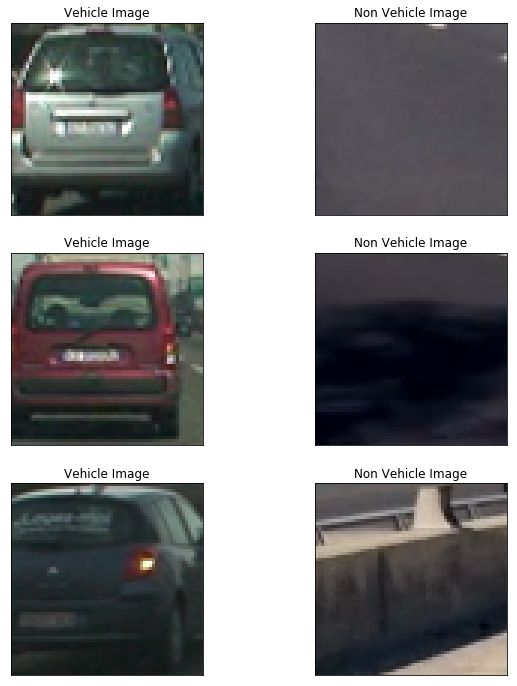

In [3]:
### Plot random images from dataset
fig = plt.figure(figsize=(10, 12))

# Create subplots in figure
for r in range(6):
    img = fig.add_subplot(3,2,r+1)
    if r%2==0:
        idx = np.random.randint(1,len(cars))
        plt.imshow(mpimg.imread(cars[idx]))
        img.set_title("Vehicle Image")
    else:
        idx = np.random.randint(1,len(notcars))
        plt.imshow(mpimg.imread(notcars[idx]))
        img.set_title("Non Vehicle Image")
        
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [6]:
### Helper functions
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            change_cspace = "cv2.COLOR_RGB2" + cspace
            feature_image = cv2.cvtColor(image, eval(change_cspace))
        else: feature_image = np.copy(image)      
            
        # Get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Get color histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Get HoG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append features
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        #features.append(np.concatenate((hist_features,hog_features)))
        
    return features

# Function to extract features from a single image
def extract_features_single(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    image = imgs

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        change_cspace = "cv2.COLOR_RGB2" + cspace
        feature_image = cv2.cvtColor(image, eval(change_cspace))
    else: feature_image = np.copy(image)      

    # Get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)

    # Get color histogram features
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Get HoG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Append features
    features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    #features.append(np.concatenate((hist_features,hog_features)))
        
    return features

In [7]:
### Parameters
cspace = 'YUV'
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pix_per_cell = 4
cell_per_block = 2
hog_channel = "ALL"

C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


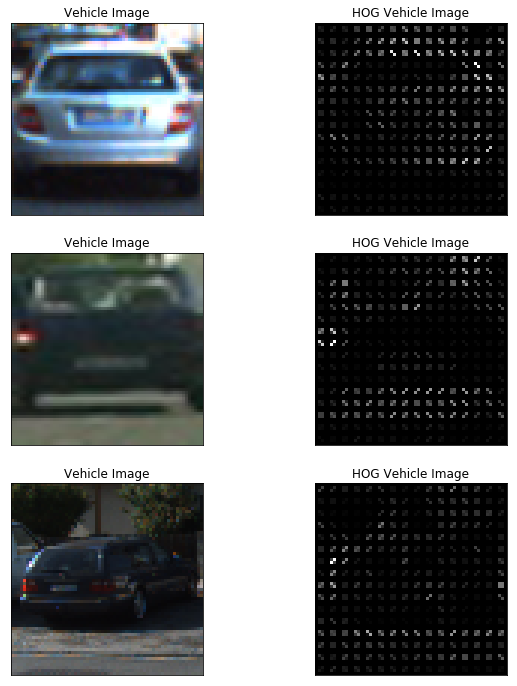

In [11]:
### Plot random images from dataset


fig = plt.figure(figsize=(10, 12))

# Create subplots in figure
for r in range(6):
    img = fig.add_subplot(3,2,r+1)
    if r%2==0:
        idx = np.random.randint(1,len(cars))
        plt.imshow(mpimg.imread(cars[idx]))
        img.set_title("Vehicle Image")
    else:
        feature_image = (mpimg.imread(cars[idx]))
        feat, feature_image = get_hog_features(feature_image[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
        plt.imshow(feature_image, cmap='gray')
        img.set_title("HOG Vehicle Image")
        
    img.set_xticks([])
    img.set_yticks([])

plt.show()

C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


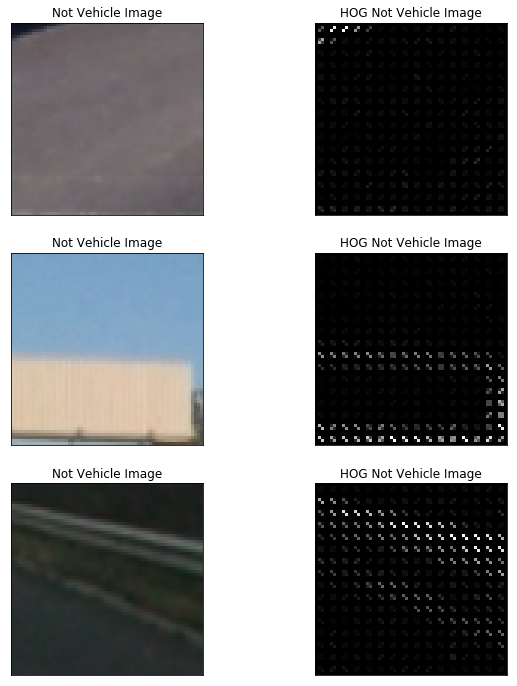

In [12]:
### Plot random images from dataset
fig = plt.figure(figsize=(10, 12))

# Create subplots in figure
for r in range(6):
    img = fig.add_subplot(3,2,r+1)
    if r%2==0:
        idx = np.random.randint(1,len(notcars))
        plt.imshow(mpimg.imread(notcars[idx]))
        img.set_title("Not Vehicle Image")
    else:
        feature_image = (mpimg.imread(notcars[idx]))
        feat, feature_image = get_hog_features(feature_image[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
        plt.imshow(feature_image, cmap='gray')
        img.set_title("HOG Not Vehicle Image")
        
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [13]:

### Obtain features

# Get features for car images
car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)


# Get features for non-car images
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [14]:
### Create training and test set

# Array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=12412)
X_train, y_train = shuffle(X_train, y_train, random_state=2342)

In [15]:

# Use a linear SVC 
svc = LinearSVC()

svc.fit(X_train, y_train)

# Check the accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9879


In [49]:
### Sliding Window
def draw_boxes(img, bboxes, color=(255, 215, 0), thick=5):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

# Search and Classify
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    # Positive detection windows
    on_windows = []
    # Iterate over all windows
    count = 0
    for window in windows:
        # Extract the test window from original image
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        
        # Extract features for that window
        features = extract_features_single(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        # Scale extracted features
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict
        prediction = svc.decision_function(test_features)
        
        # Save window if positive (prediction == 1)
        if prediction > .05:
            on_windows.append(window)
    
    return on_windows

# Heatmap
def heatmap(heatmap_image, windows):
    #global heatmap_image
    
    for window in hot_windows:
        
        heatmap_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 5

    return heatmap_image

# Threshold image
def apply_threshold(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    # Zero out pixels below the threshold
    new_heatmap[new_heatmap <= threshold] = 0
    # Return thresholded map
    return new_heatmap

# Draw boxes around label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero[0][0], nonzero[1][0])
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (148,0,211), 6)
    # Return the image
    return img

C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


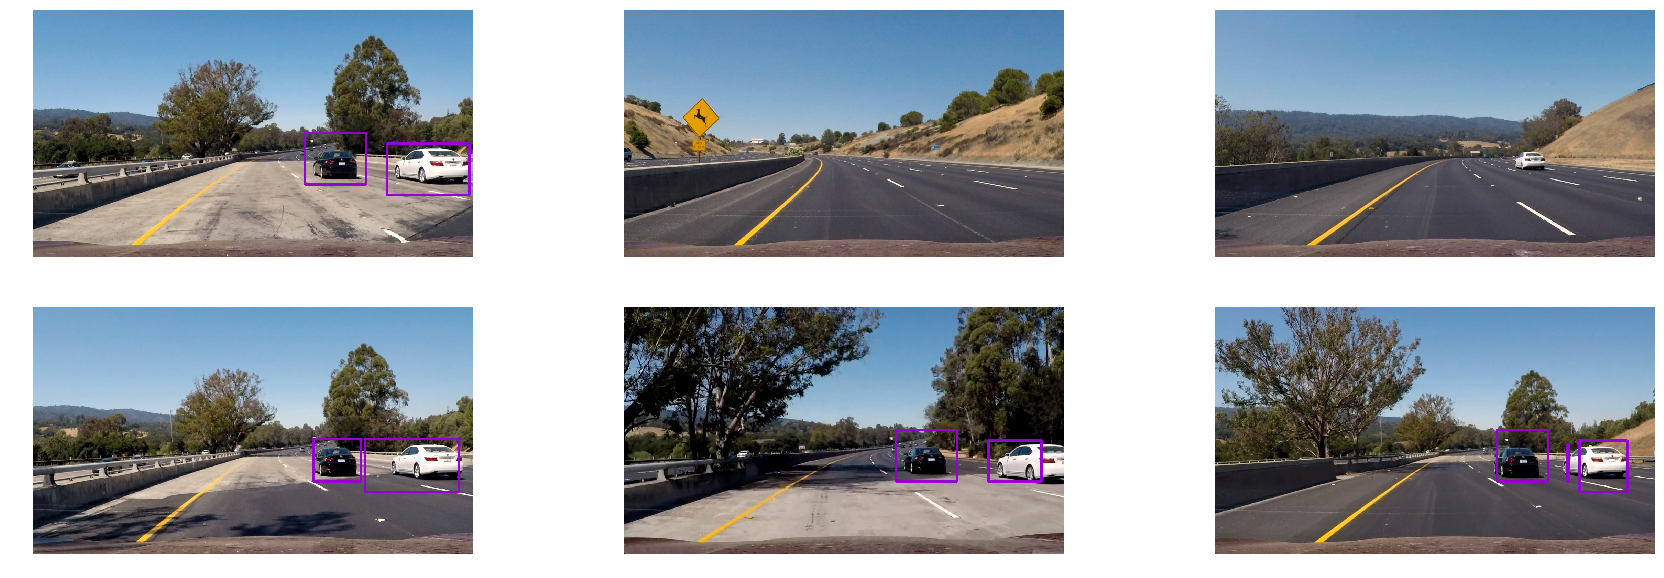

In [50]:
### Test Sliding Window on test images
images = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(30, 10))

for i in range(len(images)):
    
    car_image = mpimg.imread(images[i])
    car_image = car_image.astype(np.float32)/255

    windows1 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    
    windows2 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
    windows3 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.8), int(car_image.shape[0]/1.4)], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
    windows4 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.6), int(car_image.shape[0]/1.2)], 
                           xy_window=(160, 160), xy_overlap=(0.75, 0.75))
    
    

    windows = windows1 + windows2 + windows3 + windows4

    hot_windows = search_windows(car_image, windows, svc, X_scaler, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    heatmap_image = np.zeros_like(mpimg.imread(images[i]))
    heatmap_image = heatmap(heatmap_image, hot_windows)
    heatmap_image = apply_threshold(heatmap_image, 5)
    
    labels = label(heatmap_image)    
    
    # Boundinx Box around label
    image = draw_labeled_bboxes(mpimg.imread(images[i]), labels)
    
    # Boundinx Boxes around searched vehicle(s)
    window_img_2 = draw_boxes(mpimg.imread(images[i]), hot_windows, color=(0, 0, 255), thick=6)
    
    fig.add_subplot(2,3,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [39]:
### Slice Video into images
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
while success:
    timestamp = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3]
    cv2.imwrite("%s.jpg" % timestamp, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [ ]:
### Read and Process sliced images

global heatmaps
heatmaps = deque(maxlen = 5) #You can choose how many frames to use.

images = glob.glob("sliced_vid/*.jpg")

windows1 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(100, 100), xy_overlap=(0.75, 0.75))
    
windows2 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/2), int(car_image.shape[0]/1.6)], 
                           xy_window=(120, 120), xy_overlap=(0.75, 0.75))
    
windows3 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.8), int(car_image.shape[0]/1.4)], 
                           xy_window=(140, 140), xy_overlap=(0.75, 0.75))
     
windows4 = slide_window(car_image, x_start_stop=[int(car_image.shape[1]/2), car_image.shape[1]], 
                           y_start_stop=[int(car_image.shape[0]/1.6), int(car_image.shape[0]/1.2)], 
                           xy_window=(160, 160), xy_overlap=(0.75, 0.75))

windows = windows1 + windows2 + windows3 + windows4
    

for i in range(len(images)):
    
    car_image = mpimg.imread(images[i])
    car_image = car_image.astype(np.float32)/255 

    hot_windows = search_windows(car_image, windows, svc, X_scaler, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    
    heatmap_image = np.zeros_like(mpimg.imread(images[i]))
    heatmap_image = heatmap(heatmap_image, hot_windows)
    #heatmap_image = apply_threshold(heatmap_image, 10)
    
    

    heatmaps.append(heatmap_image)
    combined = sum(heatmaps)
    heatmap_image = apply_threshold(combined, 10)
    
    labels = label(heatmap_image)    
    
    # Boundinx Box around label
    image = draw_labeled_bboxes(mpimg.imread(images[i]), labels)
    
    # Boundinx Boxes around searched vehicle(s)
    window_img_2 = draw_boxes(mpimg.imread(images[i]), hot_windows, color=(0, 0, 255), thick=6)
    timestamp = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3]
    mpimg.imsave(str(timestamp) + ".jpg", image)
    


C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\Maxwell\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
